Author: Cristian Muñoz Villalobos

In [1]:
import tensorflow as tf
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from fuzzy_rules import extract_rules,config_input_variable,config_output_variable,define_variables,read_dataset
from sklearn.metrics import mean_squared_error,accuracy_score
from operator import itemgetter
from itertools import groupby
import os
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime
from datetime import timedelta, date
import pprint

/home/cristian/venv/RelationExtraction/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Read data with format (tab separator): 

In [45]:
cat guindaste.txt | head -5 

In [46]:
file_path='guindaste.txt'
data = read_dataset(file_path)
data.shape

(43, 3)

In [47]:
dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = np.stack([list(data) for data in dataset], axis=0)
X,y_true = dataset[:,:2],dataset[:,2:]
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.20, shuffle=False)

In [53]:
print('X_train:({})\ny_train:({})'.format(X_train.shape,y_train.shape))

X_train:((34, 2))
y_train:((34, 1))


In [71]:
x_min_value = X.min(axis=0)
x_max_value = X.max(axis=0)
y_min_value = y_true.min(axis=0)
y_max_value = y_true.max(axis=0)

# nb_outputs: suport only for nb_outputs=1
config = {
'nb_inputs':X_train.shape[-1],
'nb_outputs':y_train.shape[-1],
'nb_sets':13,
'min':[x_min_value,y_min_value],
'max':[x_max_value,y_max_value],
'resolution':1000
}

aggregation_func={
'and_func':np.fmin,
'or_func': np.fmax
}
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(config)
pp.pprint(aggregation_func)

{'max': [array([16., 30.]), array([23.21])],
 'min': [array([-44.,   0.]), array([-7.04])],
 'nb_inputs': 2,
 'nb_outputs': 1,
 'nb_sets': 13,
 'resolution': 1000}
{'and_func': <ufunc 'fmin'>, 'or_func': <ufunc 'fmax'>}


In [72]:
antecedents,consequents=define_variables(config, shoulder=False)
print(antecedents)
print(consequents)

[Antecedent: i_1, Antecedent: i_2]
[Consequent: o_1]


/home/cristian/venv/RelationExtraction/lib/python3.7/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


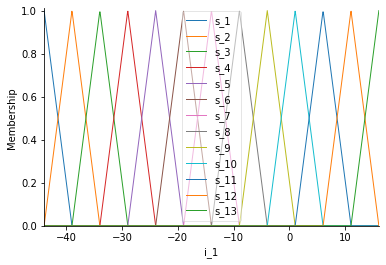

In [73]:
antecedents[0].view()

In [74]:
rules,df_rules = extract_rules(config,antecedents,consequents, X_train,y_train)

In [75]:
df_rules.head(10)

,i_1,i_2,o_1
0,s_1,s_6,s_9
1,s_11,s_1,s_2
2,s_12,s_1,s_1
3,s_2,s_6,s_10
4,s_2,s_7,s_10
5,s_3,s_2,s_8
6,s_3,s_3,s_9
7,s_3,s_6,s_11
8,s_3,s_8,s_11
9,s_4,s_2,s_8


In [76]:
%time system = ctrl.ControlSystem(rules)

CPU times: user 233 ms, sys: 0 ns, total: 233 ms
Wall time: 232 ms


In [77]:
%time sim = ctrl.ControlSystemSimulation(system)

CPU times: user 217 µs, sys: 4 µs, total: 221 µs
Wall time: 238 µs


mean_squared_error: 0.7818803423104455


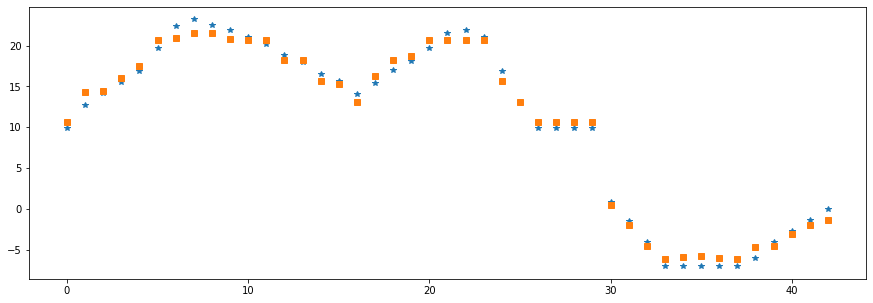

In [78]:
y_prev = []
for ind,x in enumerate(X):
    for i,x_i in enumerate(x):
        sim.input['i_{}'.format(i+1)]=x_i
    sim.compute()
    result = sim.output['o_1']
    y_prev.append(result)
    
mse = mean_squared_error(y_true, y_prev)
print('mean_squared_error: {}'.format(mse))

plt.figure(figsize=(15,5))
plt.plot(y_true,'*')
plt.plot(y_prev,'s')
plt.show()